# For classification...
using titanic dataset

# Libraries

In [33]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os
import sys
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# custom EDA functions
mypath = os.getcwd()
sys.path.append(mypath + '/code/') 
from utils import reduce_mem_usage
from categorical_encoder import label_encoding
from catplot import CategoricalVisualizer
from denseplot import DenseVisualizer

# custom modeling functions
sys.path.append(mypath + '/cls_models/') 
from base_classifier import ClassifierBase
from lgb_classifier import LgbClassifier
from catb_classifier import CatbClassifier

# stats
from scipy import stats
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

libraries imported


# Load data

In [34]:
!ls

EDA.ipynb            EDA_titanic.ipynb    inputs
EDA_houseprice.ipynb cls_models           reg_models
EDA_laputa.ipynb     code


In [35]:
# check path
datapath = "/Users/kakawagu/Documents/ScienceDevision/DataScienceComp/inputs/titanic"

files = os.listdir(datapath)
print(files)

['test.csv', 'train.csv', 'gender_submission.csv']


In [36]:
# import data
time0 = time.time()

train = pd.read_csv(datapath + '/train.csv')
test = pd.read_csv(datapath + '/test.csv')
submission = pd.read_csv(datapath + '/gender_submission.csv')

time1 = time.time()
print(time1 - time0, " seconds to load data")

0.009536981582641602  seconds to load data


In [37]:
# check train
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
# check test
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [39]:
# check submission file
print(submission.shape)
submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# EDA

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [41]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

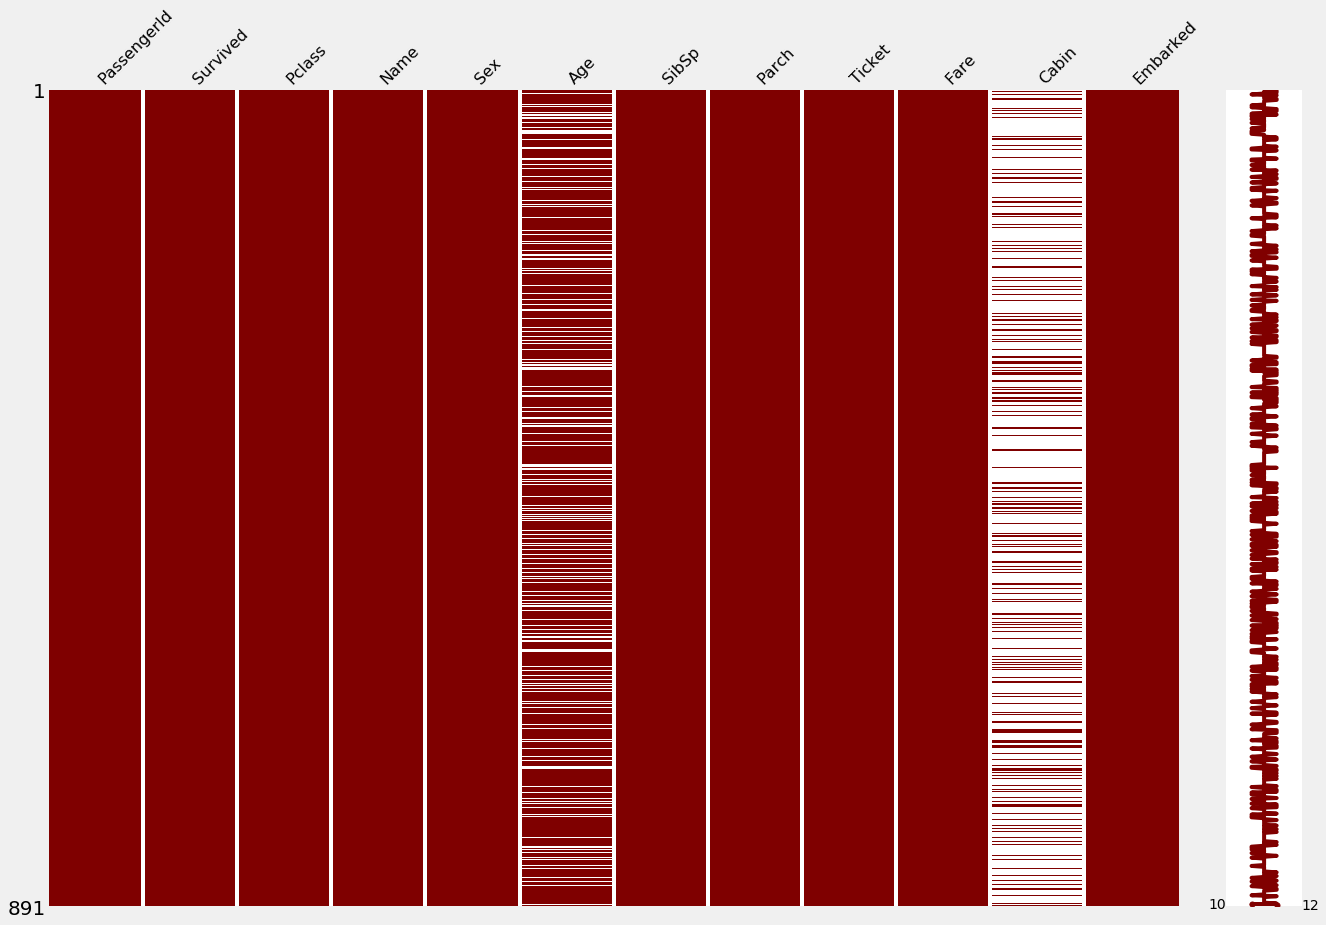

In [42]:
# missing data?
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

# Target

Text(0, 0.5, '#')

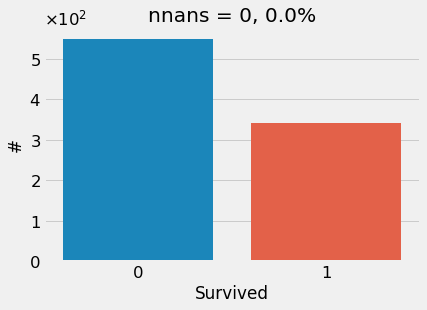

In [43]:
# hist
target = "Survived"
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(x=target, data=train, ax=ax)
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="x",scilimits=(0,0))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
ax.set_title("nnans = {}, {}%".format(train[target].isna().sum(), 100 * train[target].isna().sum() / train.shape[0]))
ax.set_xlabel(target)
ax.set_ylabel("#")

In [44]:
# roughly categorize features
cat_features = []
dense_features = []
for f in train.columns.values.tolist():
    if f != target:
        if (train[f].dtype == "object") | (train[f].dtype == "bool"):
            cat_features.append(f)
        else:
            dense_features.append(f)
features = dense_features + cat_features
print(f"There are {len(features)} features.")
print(f"There are {len(dense_features)} dense features.")
print(f"There are {len(cat_features)} categorical features.")

There are 11 features.
There are 6 dense features.
There are 5 categorical features.


# Dense features

In [45]:
vd = DenseVisualizer(train=train, test=test, features=dense_features, target=target)
chkd = vd.column_checker()

feature name = PassengerId
feature name = Pclass
feature name = Age
feature name = SibSp
feature name = Parch
feature name = Fare


In [46]:
chkd.style.background_gradient()

,features,train_nans,test_nans,train_nunique,test_nunique,train_min,test_min,train_max,test_max,train_mean,test_mean,train_skew,test_skew
0,PassengerId,0,0,891,418,1,892,891,1309,446,1100.5,0,0
1,Pclass,0,0,3,3,1,1,3,3,2.30864,2.26555,-0.630548,-0.53417
2,Age,177,86,88,79,0.42,0.17,80,76,29.6991,30.2726,0.389108,0.457361
3,SibSp,0,0,7,7,0,0,8,8,0.523008,0.447368,3.69535,4.16834
4,Parch,0,0,7,8,0,0,6,9,0.381594,0.392344,2.74912,4.65446
5,Fare,0,1,248,169,0,0,512.329,512.329,32.2042,35.6272,4.78732,3.68721


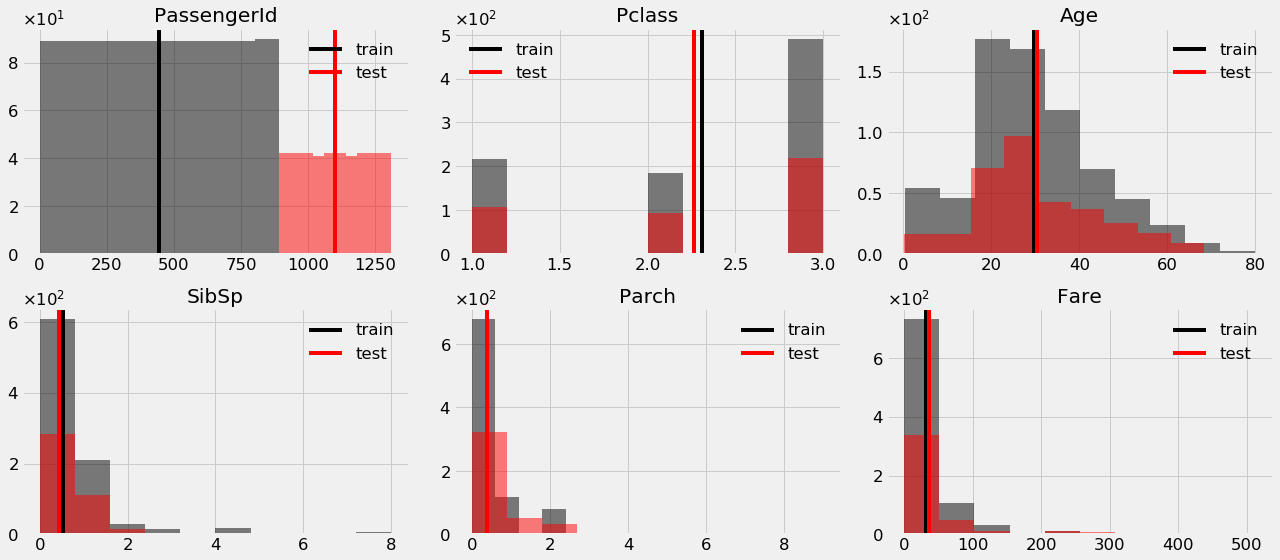

In [47]:
vd.plot_bars()

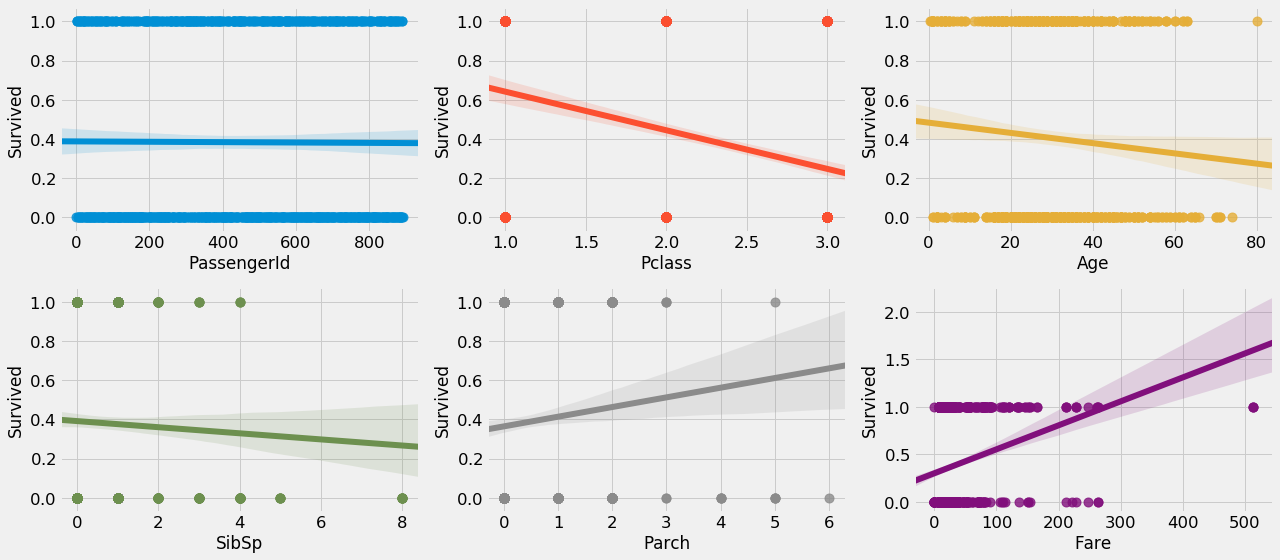

In [48]:
vd.plot_vs_target()

# Categorical features

In [49]:
# EDA for categorical features
vc = CategoricalVisualizer(train=train, test=test, features=cat_features, target=target)
chkc = vc.column_checker()

feature name = Name
feature name = Sex
feature name = Ticket
feature name = Cabin
feature name = Embarked


In [50]:
chkc.style.background_gradient()

,features,overlap,train_nans,test_nans,train_nunique,test_nunique
0,Name,1.46689,0,0,891,418
1,Sex,1,0,0,2,2
2,Ticket,1.36417,0,0,681,363
3,Cabin,1.27211,687,327,147,76
4,Embarked,1.33333,2,0,3,3


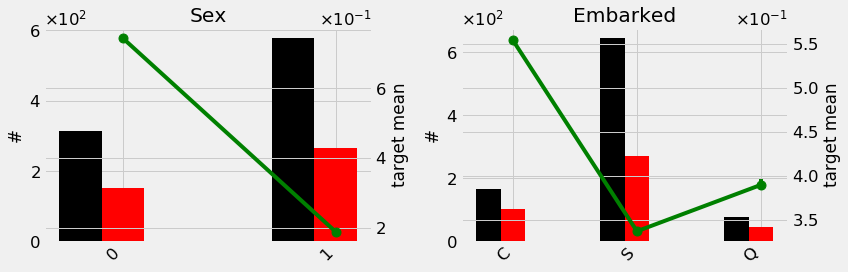

In [57]:
cat_features = ["Sex", "Embarked"]
vc = CategoricalVisualizer(train=train, test=test, features=cat_features, target=target)
vc.plot_bars()

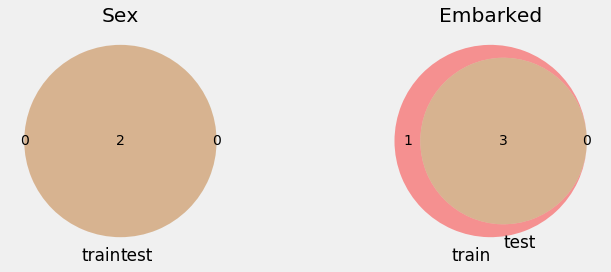

In [58]:
vc.plot_venn()

In [53]:
cat_features = ["Sex"]

# Fit LGB and Get Feature importance

In [61]:
features = dense_features + cat_features
print(features)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']


In [63]:
# label encoding object features
train, test = label_encoding(train, test, features)
train = train[features + [target]]
test = test[features]
train.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Survived
0,1,3,22.0,1,0,7.2500,1,2,0
1,2,1,38.0,1,0,71.2833,0,0,1
2,3,3,26.0,0,0,7.9250,0,2,1
3,4,1,35.0,1,0,53.1000,0,2,1
4,5,3,35.0,0,0,8.0500,1,2,0


In [64]:
train[target].isna().sum()

0

In [65]:
features = dense_features + cat_features
target in features

False

In [66]:
# fit LGB
lgbcls = LgbClassifier(train, test, target, features, categoricals=cat_features, cv_method="StratifiedKFold")

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.966206	valid_1's auc: 0.841434
Early stopping, best iteration is:
[74]	training's auc: 0.955697	valid_1's auc: 0.845892
Partial score of fold 0 is: 0.8458920525357109
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.959825	valid_1's auc: 0.878439
Early stopping, best iteration is:
[11]	training's auc: 0.875875	valid_1's auc: 0.903533
Partial score of fold 1 is: 0.9035327389512031
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.957483	valid_1's auc: 0.848433
Early stopping, best iteration is:
[35]	training's auc: 0.918716	valid_1's auc: 0.851045
Partial score of fold 2 is: 0.8510449621321062
Our oof loss score is:  0.8510050170964751


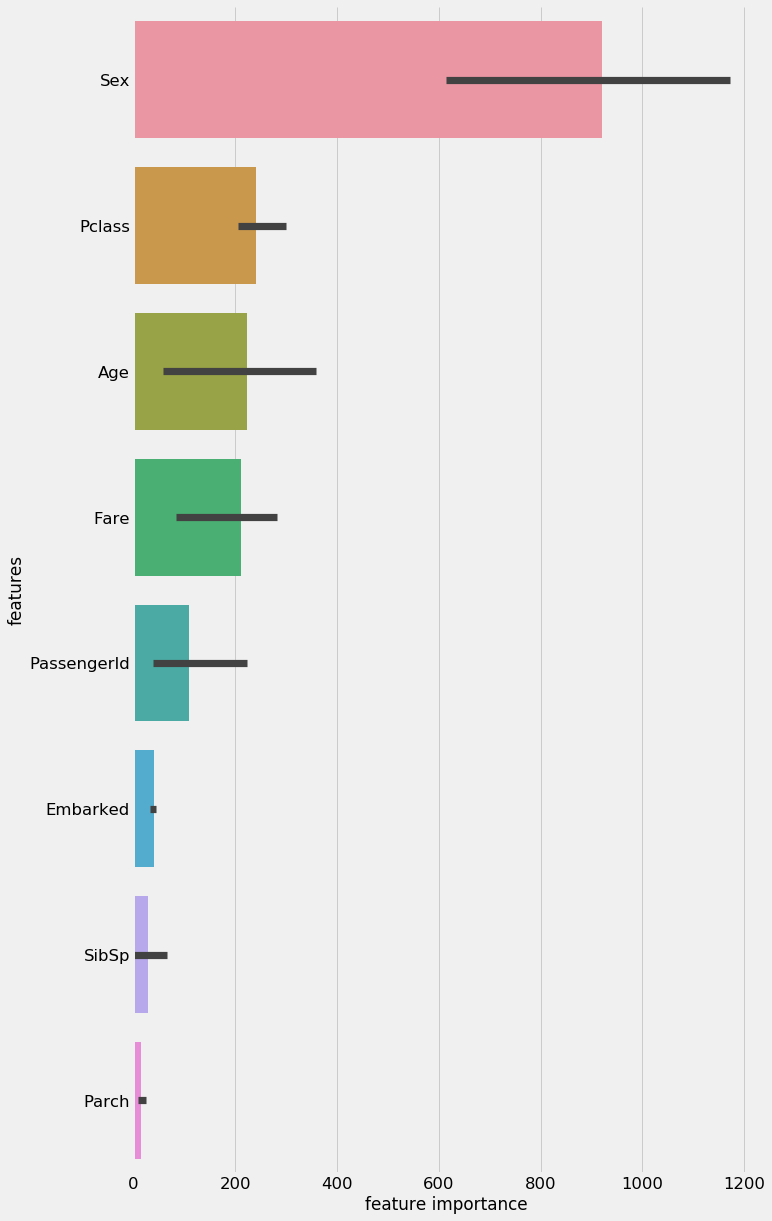

In [67]:
# plot feature importance
lgbcls.plot_feature_importance(rank_range=[1,100])